## Data Collection

Main data collection is done by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This data collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [1]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

This project will analyze a selection of news channels on Youtube, since they produce a large number of videos covering a variety of topics.

In [2]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes
channel_id_list = ['UCBi2mrWuNuyYy4gbM6fU18Q'] #ABCNews
channel_id_list = ['UCeY0bbntWzzVIaj2z3QigXg'] #NBCNews
channel_id_list = ['UCaXkIU1QidjPwiAYu6GcHjg'] #MSNBC

In [3]:
# Create Youtube Data API object & cleaned dataframe containing video data from selected channel using function from youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object

Data uploaded to the MySQL database can be pulled by uncommenting the code cell below. Rest of the analysis uses direct usage of the Youtube Data API functions for dynamic analysis of multiple channels.

In [4]:
# host_name, dbname, schema_name, port, username, password = get_db_info() # imports sensitive auth. information from .env file
# cnx = connect_to_db(username, password, host_name, schema_name, port) # creates connection object
# cursor = cnx.cursor() # activates connection cursor
# video_df = return_df_from_db('videos', cursor)

Directly using the Youtube Data API:

In [5]:
video_df = create_video_df(youtube_obj, channel_id_list, 500) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [6]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [7]:
video_ids = list(selected_df['video_id'])

## Exploratory Data Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

#### Does the number of likes and comments matter for a video to get more views?

<Figure size 1008x504 with 0 Axes>

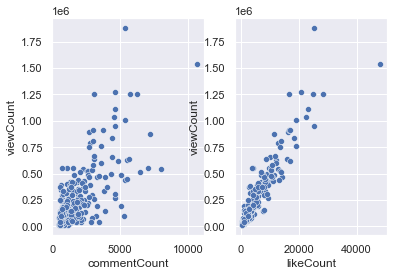

<Figure size 1008x504 with 0 Axes>

In [9]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "likeCount", y = "viewCount", ax=ax[1])
plt.figure(figsize = (14,7))

#### Does the video duration matter for views and interaction (likes/comments)?

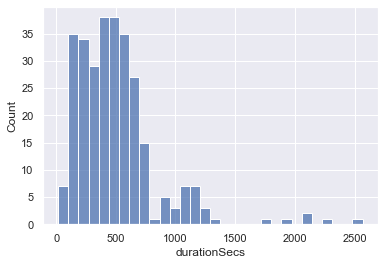

In [10]:
sns.histplot(data=selected_df[selected_df['durationSecs'] < 10000], x="durationSecs", bins=30)
sns.set(rc = {'figure.figsize':(13,7)})

Plotting the duration against comment count and like count, it can be seen that shorter videos tend to get more likes and comments than very long videos.

<Figure size 1008x504 with 0 Axes>

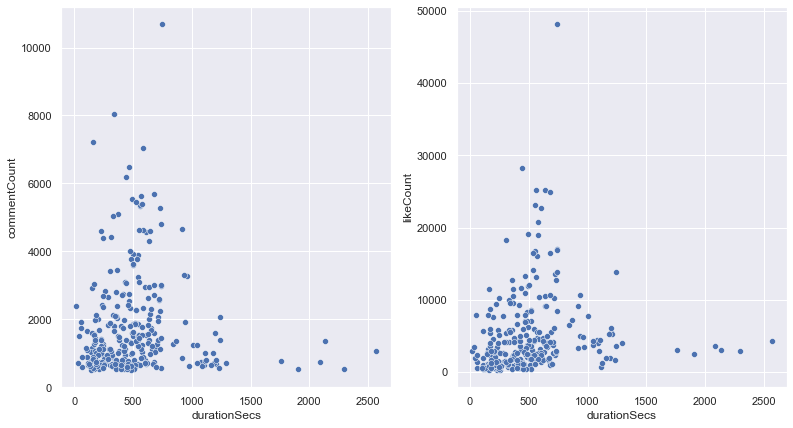

<Figure size 1008x504 with 0 Axes>

In [11]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "durationSecs", y = "likeCount", ax=ax[1])
plt.figure(figsize = (14,7))

#### Which day in the week are most videos uploaded?

It's interesting to see that most videos are posted Tuesday and Saturday. Fewer videos are posted on Mondays and Sundays. This could be because of the nature of news channels, where most of the event coverage happens during the weekdays. But it could also mean that most of the workers produce the most output and coverage during typical working days.

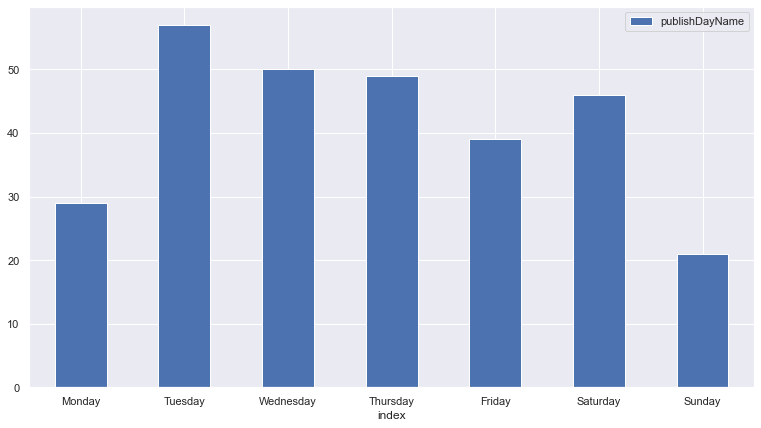

In [12]:
day_df = pd.DataFrame(selected_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)

## VADER NLP

### Comment Extraction & Data Cleaning

In [13]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [14]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,VOnN-qnONNo,UgzoN9xuILFGHSjLV9l4AaABAg,STAY MAD LEFTIES LOOOOL,2022-09-23T05:12:47Z
1,VOnN-qnONNo,UgxHR_uVvTCLvojD5FZ4AaABAg,msnbc is fake news,2022-09-23T05:12:39Z
2,VOnN-qnONNo,UgyxRVBuQVT2l7zbNv14AaABAg,"Democrats love migrants, but they just don't w...",2022-09-23T05:12:22Z
3,VOnN-qnONNo,Ugxi6dVIykG0p8i1joJ4AaABAg,LOL LOL LOL hundreds of thousands of immigrant...,2022-09-23T05:11:53Z
4,VOnN-qnONNo,Ugz9ffuAp2QNp07zg0J4AaABAg,Why could Joe Biden send over 70 flights acros...,2022-09-23T05:09:19Z


In [15]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

### Sentiment Analysis (VADER Model)

In [16]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [17]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [18]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [19]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,VOnN-qnONNo,DeSantis Keeps Migrant Plane Stunt Funding Opa...,-0.025559,22288,743.0
1,zgh2dYlCHIM,Why The DeSantis Migrant Stunt Could Be The Ne...,-0.022922,28557,1129.0
2,MMc5lfQc8Q0,Trump Admits To Willful Retention Of Documents...,-0.053093,106996,3405.0
3,NVXg70eLwDk,Joy Reid: Trump May Have Indicated He Intentio...,0.012714,175569,3812.0
4,Mjq8-UGLVTY,DeSantis Investigated And Sued Over Migrant Fl...,-0.140086,50757,1970.0
...,...,...,...,...,...
286,pQRsgoJa2KY,Stefanik 'Maintains A Separate Set Of Rules' F...,-0.034650,103356,2532.0
287,4vgnvYnwfDY,Michael Cohen: Bill Barr ‘Is A Coward’ | The K...,-0.066095,915029,16856.0
288,reulz2LYtqU,GOP Plans Impeachment Of Biden Officials If Th...,-0.040754,519101,6976.0
289,j-zKfQa-0u8,Hot Button Cultural Issues Become Winning Topi...,0.021833,39267,1168.0


### Sentiment Analysis Data Visualization (Plotly)

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

Find the interactive graph [here](https://cjunwon.github.io/Youtube-Data-Analysis/).

In [21]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark'
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='vscode')

pio.write_html(fig, file='index.html', auto_open=True)

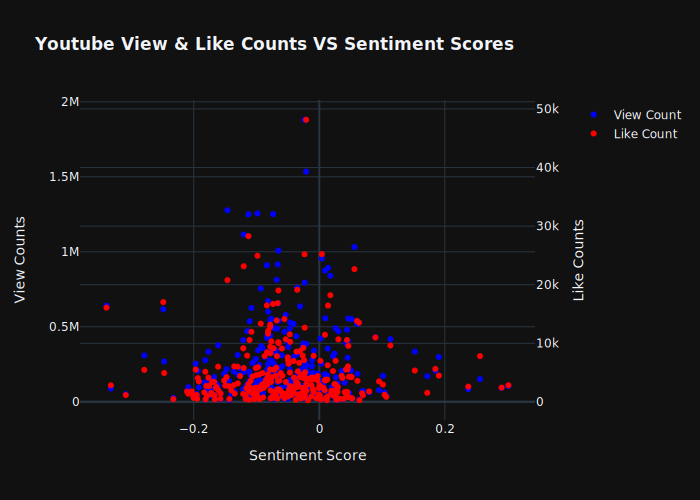

In [22]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark',
    autosize=True
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='svg')

# pio.write_html(fig, file='index.html', auto_open=True)

Below is a bubble chart with bubble size and color set as a scaled composite sentiment score per video. Initial sentiment scores ranged from -1 to 1, but they were scaled to all be positive values to plot as a bubble chart.

In [23]:
scaled_sentiment_df = video_comp_sentiments.copy()
scaled_sentiment_df['avg_comp_sentiment'] = np.where(scaled_sentiment_df['avg_comp_sentiment'] > 0, scaled_sentiment_df['avg_comp_sentiment'] * 2, scaled_sentiment_df['avg_comp_sentiment'])
scaled_sentiment_df['avg_comp_sentiment'] = np.where(scaled_sentiment_df['avg_comp_sentiment'] < 0, scaled_sentiment_df['avg_comp_sentiment'] * -1, scaled_sentiment_df['avg_comp_sentiment'])

In [24]:
import plotly.express as px

fig = px.scatter(test_df, x="vid_viewcount", y="vid_likecount",
	         size="avg_comp_sentiment",
             color="avg_comp_sentiment", hover_name="vid_title", log_x=True)
fig.show(renderer='svg')

NameError: name 'test_df' is not defined